# SVD Plots

### Importing Libraries

In [8]:
from keras import backend as K
from keras import regularizers
import numpy as np
from gensim_download import pickle_rw
from keras.layers import Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
import plotly.plotly as py
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy.linalg

from numpy.linalg import det

from numpy.linalg import inv

import sympy as sympy

from sympy import Matrix


### Defining Functions

In [9]:
def make_dict(vocab, vectors):
    """Make dictionary of vocab and vectors"""
    return {vocab[i]: vectors[i] for i in range(len(vocab))}


def vocab_train_test(embedding, lg1, lg2, lg1_vocab):
    """Create training and test vocabularies"""
    if embedding == 'zeroshot':
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_train_5K.txt') as f:
            vocab_train = [(_.split(' ')[0], _.split(' ')[1])
                           for _ in f.read().split('\n')[:-1]]
        with open('../data/zeroshot/transmat/data/' +
                  'OPUS_en_it_europarl_test.txt') as f:
            vocab_test = [(_.split(' ')[0], _.split(' ')[1])
                          for _ in f.read().split('\n')[:-1]]

    elif embedding in ['fasttext_random', 'fasttext_top']:
        embedding, split = embedding.split('_')
        lg1_lg2, lg2_lg1 = pickle_rw((lg1 + '_' + lg2, 0),
                                     (lg2 + '_' + lg1, 0), write=False)
        # T = Translation, R = Reverse (translated and then translated back)
        # Create vocab from 2D translations
        vocab_2D = []
        for lg1_word in lg1_vocab:
            # Translate lg1_word
            if lg1_word in lg1_lg2:
                lg1_word_T = lg1_lg2[lg1_word]

                # Check if translated word (or lowercase) is in lg2_lg1
                if lg1_word_T in lg2_lg1.keys():
                    lg1_word_R = lg2_lg1[lg1_word_T]
                elif lg1_word_T.lower() in lg2_lg1.keys():
                    lg1_word_T = lg1_word_T.lower()
                    lg1_word_R = lg2_lg1[lg1_word_T]
                else:
                    lg1_word_R = None

                # Check if lg1_word and lg1_word_R are equal (lowercase)
                if lg1_word_R:
                    if lg1_word.lower() == lg1_word_R.lower():
                        vocab_2D.append((lg1_word, lg1_word_T))
        print('length of '+ lg1+'-'+ lg2+ ' vocab: '+str(len(vocab_2D)))

        #Create Train/Test vocab

        if split == 'random':
            sample = np.random.choice(len(vocab_2D), 6500, replace=False)
            vocab_train = np.asarray(vocab_2D)[sample[:5000]].tolist()
            vocab_test = np.asarray(vocab_2D)[sample[5000:]].tolist()
        elif split == 'top':
            sample = np.random.choice(range(6500), 6500, replace=False)
            vocab_train = np.asarray(vocab_2D)[:5000, :].tolist()
            vocab_test = np.asarray(vocab_2D)[:1500, :].tolist()
        else:
            pass

        # if split == 'random':
        #     sample = np.random.choice(len(vocab_2D), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[sample[:700]].tolist()
        #     vocab_test = np.asarray(vocab_2D)[sample[700:]].tolist()
        # elif split == 'top':
        #     sample = np.random.choice(range(900), 900, replace=False)
        #     vocab_train = np.asarray(vocab_2D)[:700, :].tolist()
        #     vocab_test = np.asarray(vocab_2D)[:200, :].tolist()
        # else:
        #     pass

    return vocab_train, vocab_test


def vectors_train_test(vocab_train, vocab_test):
    """Create training and test vectors"""
    X_train, y_train = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                             for lg1_word, lg2_word in vocab_train])
    X_test, y_test = zip(*[(lg1_dict[lg1_word], lg2_dict[lg2_word])
                           for lg1_word, lg2_word in vocab_test])
    return map(np.asarray, (X_train, X_test, y_train, y_test))


def translation_matrix(X_train, y_train):
    """Fit translation matrix T"""
    model = Sequential()
    model.add(Dense(300, use_bias=False, input_shape=(X_train.shape[1],),kernel_regularizer=regularizers.l2(0.01)))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, y_train, batch_size=128, epochs=20,
                        verbose=False)
    T = model.get_weights()[0]

    T = np.matrix(T)

    M = np.multiply(np.matrix(T),100)

    T_norm, T_normed = normalize(M)

    D = np.linalg.det(M)
    
    I = inv(T)
    
    #Fr_norm = np.linalg.det(np.subtract(np.matmul(M,M.getH()),np.matmul(M.getH(),M)))
    
    Fr_norm = np.linalg.det(np.matrix(np.subtract(np.matmul(T,T.getH()),np.matmul(T.getH(),T))))
    
    #print(T_normed)
    #print(T_normed.getH())

    #print(np.around(np.matmul(T_normed,T_normed.getH())))

    #print(np.around(np.matmul(T_normed.getH(),T_normed)))

    print ("Determinant:"+str(D))
    
    print ("Fr_norm:"+str(Fr_norm))

    if np.array_equal(np.around(np.matmul(T_normed,T_normed.getH())), np.around(np.matmul(T_normed.getH(),T_normed))) == True:
        tf = "True"
    else:
        tf = "False"

    return model, history, T, D, tf, I

def translation_accuracy(X_test, y_test):
    """Get predicted matrix 'yhat' using 'T' and find translation accuracy"""
    # yhat
    yhat = X.dot(T)
    count = 0
    for i in range(len(y_test)):
        if yhat[i,:].all() == y_test[i,:].all():
            count = count + 1
    accuracy = count/len(y_test)*100
    return accuracy

def svd(T):
    """Perform SVD on the translation matrix 'T' """
    U, s, Vh = numpy.linalg.svd(T, full_matrices=False )
    return U, s, Vh

def T_svd_EDA(s):
    """Perform SVD on the translation matrix 'T' """
    plt.hist(s, bins='auto', range = (0,1),normed = 1)
    plt.show()




def normalize(matrix):
    """Normalize the rows of a matrix"""
    matrix_norm = np.linalg.norm(matrix, axis=1)
    matrix_normed = matrix / np.repeat(matrix_norm, matrix.shape[1]). \
        reshape(matrix.shape)
    return matrix_norm, matrix_normed


def translation_results(X, y, vocab, T, lg2_vectors, lg2_vocab):
    """X, y, vocab - The training or test data that you want results for
    T - The translation matrix
    lg2_vectors, lg2_vocab - Foreign language used to find the nearest neighbor
    """

    # Data Prep on Inputs
    X_word, y_word = zip(*vocab)
    X_norm, X_normed = normalize(X)
    y_norm, y_normed = normalize(y)
    lg2_vectors_norm, lg2_vectors_normed = normalize(lg2_vectors)

    # yhat
    yhat = X.dot(T)
    yhat_norm, yhat_normed = normalize(yhat)



    # Nearest Neighbors
    neg_cosine = -yhat_normed.dot(lg2_vectors_normed.T)
    ranked_neighbor_indices = np.argsort(neg_cosine, axis=1)

    # Nearest Neighbor
    nearest_neighbor_indices = ranked_neighbor_indices[:, 0]
    yhat_neighbor = lg2_vectors[nearest_neighbor_indices, :]
    yhat_neighbor_norm, yhat_neighbor_normed = normalize(yhat_neighbor)
    yhat_neighbor_word = np.asarray(lg2_vocab)[nearest_neighbor_indices]

    # Results DF
    cols = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm',
            'X_word', 'y_word', 'yhat_neighbor_word']
    results_df = pd.DataFrame({'X_norm': X_norm,
                               'y_norm': y_norm,
                               'yhat_norm': yhat_norm,
                               'yhat_neighbor_norm': yhat_neighbor_norm,
                               'X_word': X_word,
                               'y_word': y_word,
                               'yhat_neighbor_word': yhat_neighbor_word,})
    results_df = results_df[cols]
    results_df['neighbor_correct'] = results_df.y_word == \
        results_df.yhat_neighbor_word

    return results_df


def T_norm_EDA(results_df):
    """Plot result norms side-by-side"""
    test_size = results_df.shape[0]
    test_accuracy = round(results_df.neighbor_correct.mean(), 2)

    print('Test Accuracy: '+str(test_accuracy)+'\n')

    plot_data = ['X_norm', 'y_norm', 'yhat_norm', 'yhat_neighbor_norm']
    # f, ax = plt.subplots(len(plot_data), sharex=True, sharey=True,
    #                      figsize=(10, 10))
    # for i, d in enumerate(plot_data):
    #     ax[i].hist(results_df[d], bins=100)
    #     ax[i].axis('off')
    #     title = '{}: mean={}, std={}'.format(d, round(results_df[d].mean(), 2), round(results_df[d].std(), 2))
    #     ax[i].set_title(title)
    # f.subplots_adjust(hspace=0.7)
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_norm.png')
    # plt.close('all')
    return


def T_pca_EDA(T):
    """PCA on matrix T"""
    T_ss = StandardScaler().fit_transform(T)
    pca = PCA().fit(T_ss)
    n = pca.n_components_

    # plt.figure(figsize=(10, 6))
    # plt.xlim((0, n))
    # plt.ylim((0, 1))
    # plt.plot(range(n + 1), [0] + np.cumsum(pca.explained_variance_ratio_).
    #          tolist())
    # plt.plot(range(n + 1), np.asarray(range(n + 1)) / n)
    # plt.xlabel('Number of Eigenvectors')
    # plt.ylabel('Explained Variance')
    # plt.savefig('../images/' + lg1 + '_' + lg2 + '_' + embedding +
    #             '_T_isotropy.png')
    # plt.close('all')

    isotropy = (1 - sum(np.cumsum(pca.explained_variance_ratio_) * 1 / n)) / .5
    return isotropy


def T_report_results(embedding, lg1, lg2, lg1_vectors, lg2_vectors,
                     X_train, X_test, D, results_df, isotropy):
    md = '## ' + lg1.title() + ' to ' + lg2.title() + ' ' + \
        embedding.title() + '  \n'
    md += '- ' + lg1.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[0]) + '  \n'
    md += '- ' + lg1.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg1_vectors.shape[1]) + '  \n'
    md += '- ' + lg2.title() + ' Vocabulary Size = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[0]) + '  \n'
    md += '- ' + lg2.title() + ' Embedding Length = ' + \
        '{:,.0f}'.format(lg2_vectors.shape[1]) + '  \n'
    md += '- Train Size = ' + '{:,.0f}'.format(X_train.shape[0]) + '  \n'
    md += '- Test Size = ' + '{:,.0f}'.format(X_test.shape[0]) + '  \n'
    md += '- Determinant = ' + '{:,.0f}'.format(D) + '  \n'

    md += '- <b>Test Accuracy = ' + \
        '{:,.1%}'.format(results_df.neighbor_correct.mean()) + '</b>  \n\n'



    md += '#### Test L2 Norms  \n'
    md += '- X_norm: L2 norms for ' + lg1.title() + ' test vectors  \n'
    md += '- y_norm: L2 norms for ' + lg2.title() + ' test vectors  \n'
    md += '- yhat_norm: L2 norms for X.dot(T) test vectors ' + \
        '(T = translation matrix)  \n'
    md += '- yhat_neighbor norm: L2 norms for nearest neighbor' + \
        'to X.dot(T) in y test vectors  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_norm.png)  \n\n'

    md += '#### Translation Matrix Isotropy  \n'
    md += '- Isotropy = ' + '{:,.1%}'.format(isotropy) + '  \n'
    md += '![](../images/' + lg1 + '_' + lg2 + '_' + embedding + \
        '_T_isotropy.png)  \n\n'

    return md

### Main Function ( with SVD stats )

Translation: en->ru

length of en-ru vocab: 6839
Determinant:6.90434e-20
Fr_norm:0.0
biggest element:0.0242678

min: -4.61785

max: -0.177715

mean: -2.06387

median: -2.01758

std: 0.562613



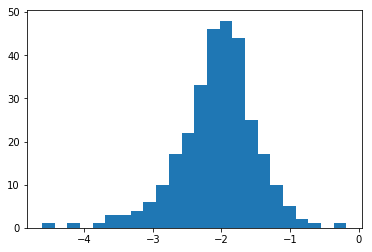

Translation: en->de

length of en-de vocab: 16693
Determinant:5.6712e-19
Fr_norm:0.0
biggest element:0.0249038

min: -4.58891

max: -0.193352

mean: -2.06082

median: -2.00659

std: 0.563998



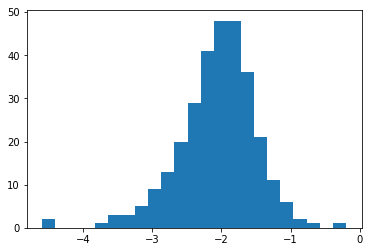

Translation: en->es

length of en-es vocab: 10422
Determinant:1.70048e-23
Fr_norm:-0.0
biggest element:0.0248436

min: -5.0756

max: -0.251618

mean: -2.0759

median: -2.01594

std: 0.565509



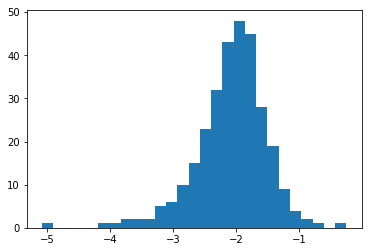

Translation: en->zh-CN

length of en-zh-CN vocab: 1460
Determinant:0.0
Fr_norm:0.0
biggest element:0.0175583

min: -4.81817

max: -0.272723

mean: -2.40022

median: -2.36174

std: 0.585884



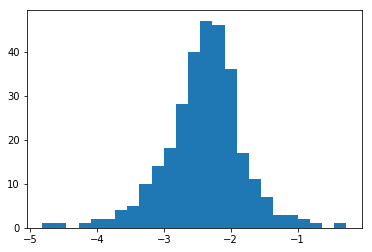

Translation: de->en

length of de-en vocab: 16693
Determinant:-1.24903e-17
Fr_norm:0.0
biggest element:0.0212076

min: -5.1774

max: -0.254686

mean: -2.05634

median: -1.99594

std: 0.565205



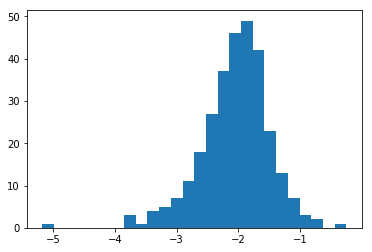

Translation: de->es

length of de-es vocab: 11456
Determinant:-3.17871e-24
Fr_norm:-0.0
biggest element:0.0245577

min: -4.64758

max: -0.2367

mean: -2.07833

median: -2.03117

std: 0.575503



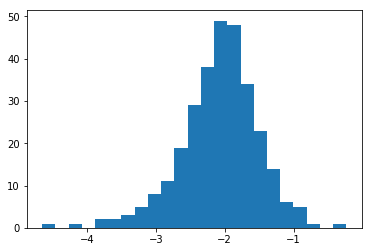

Translation: de->ru

length of de-ru vocab: 5910
Determinant:-5.87922e-20
Fr_norm:-0.0
biggest element:0.0220227

min: -4.7186

max: -0.176533

mean: -2.0641

median: -2.02372

std: 0.582601



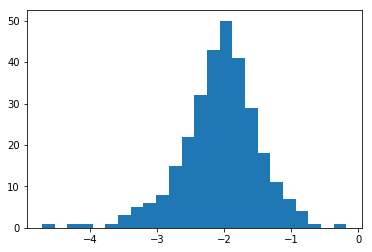

Translation: de->zh-CN

length of de-zh-CN vocab: 1820
Determinant:-0.0
Fr_norm:0.0
biggest element:0.0194821

min: -5.21761

max: -0.160667

mean: -2.41954

median: -2.37113

std: 0.585436



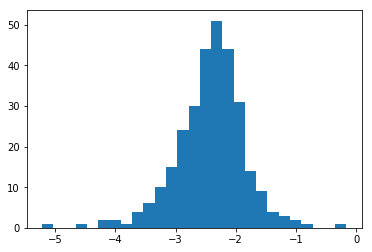

Translation: ru->en

length of ru-en vocab: 6839
Determinant:2.38079e-20
Fr_norm:-0.0
biggest element:0.0189663

min: -4.29942

max: -0.270539

mean: -2.06541

median: -2.01864

std: 0.56294



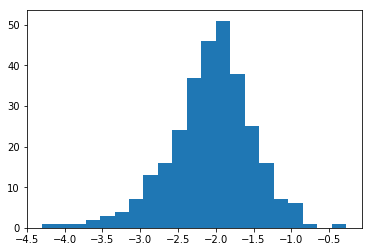

Translation: ru->es

length of ru-es vocab: 5870
Determinant:2.92967e-23
Fr_norm:-0.0
biggest element:0.0274125

min: -4.27433

max: -0.246306

mean: -2.07511

median: -2.03295

std: 0.563997



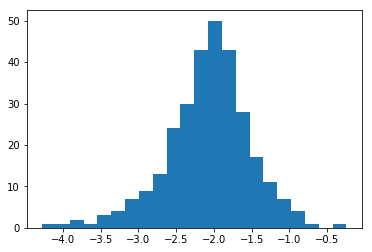

Translation: ru->zh-CN

length of ru-zh-CN vocab: 1266
Determinant:0.0
Fr_norm:0.0
biggest element:0.0170142

min: -4.87617

max: -0.174016

mean: -2.1899

median: -2.11726

std: 0.52463



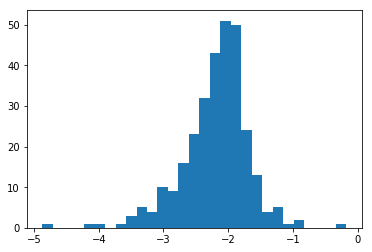

Translation: ru->de

length of ru-de vocab: 5910
Determinant:1.47292e-21
Fr_norm:-0.0
biggest element:0.0249148

min: -4.64469

max: -0.195956

mean: -2.06944

median: -2.0281

std: 0.58387



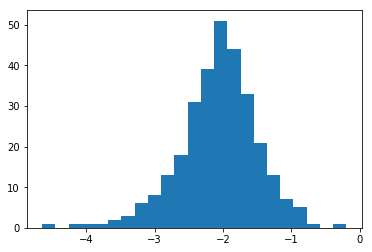

Translation: zh-CN->en

length of zh-CN-en vocab: 1460
Determinant:-0.0
Fr_norm:-0.0
biggest element:0.0190999

min: -5.05474

max: -0.222722

mean: -2.37819

median: -2.33393

std: 0.586227



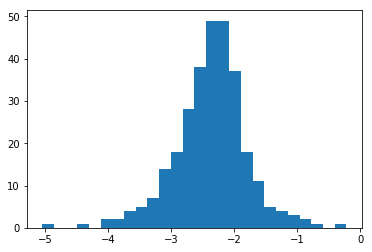

Translation: zh-CN->es

length of zh-CN-es vocab: 1164
Determinant:-0.0
Fr_norm:-0.0
biggest element:0.0216832

min: -4.37735

max: -0.226814

mean: -2.1568

median: -2.08155

std: 0.518682



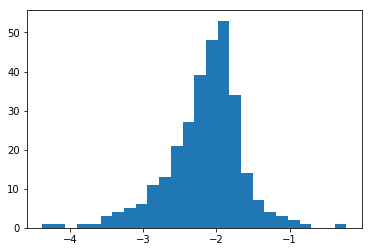

Translation: zh-CN->ru

length of zh-CN-ru vocab: 1266
Determinant:-0.0
Fr_norm:0.0
biggest element:0.0153408

min: -4.93457

max: -0.249857

mean: -2.18966

median: -2.11107

std: 0.536117



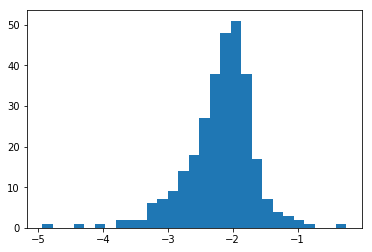

Translation: zh-CN->de

length of zh-CN-de vocab: 1820
Determinant:0.0
Fr_norm:0.0
biggest element:0.0151794

min: -4.92075

max: -0.274514

mean: -2.37988

median: -2.32196

std: 0.574779



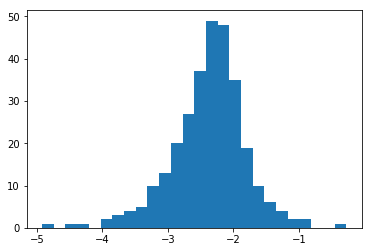

Translation: es->en

length of es-en vocab: 10422
Determinant:-4.27573e-22
Fr_norm:0.0
biggest element:0.02244

min: -5.18346

max: -0.259045

mean: -2.07123

median: -2.00492

std: 0.573495



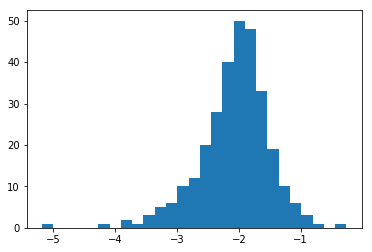

Translation: es->de

length of es-de vocab: 11456
Determinant:4.63294e-23
Fr_norm:-0.0
biggest element:0.0241022

min: -4.9976

max: -0.186252

mean: -2.07445

median: -2.02945

std: 0.580723



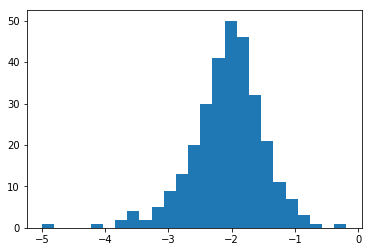

Translation: es->ru

length of es-ru vocab: 5870
Determinant:1.68592e-22
Fr_norm:0.0
biggest element:0.034432

min: -4.65673

max: -0.159912

mean: -2.07258

median: -2.02386

std: 0.585833



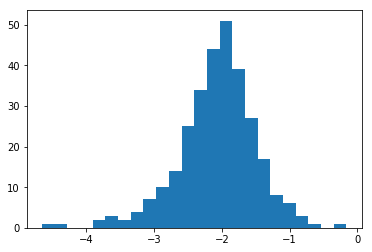

Translation: es->zh-CN

length of es-zh-CN vocab: 1164
Determinant:-0.0
Fr_norm:0.0
biggest element:0.0252429

min: -4.87733

max: -0.285547

mean: -2.18083

median: -2.09858

std: 0.527356



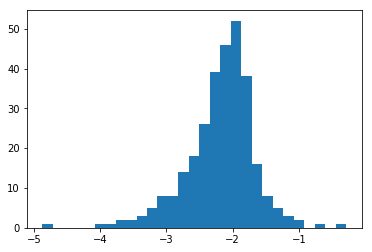

In [7]:
if __name__ == '__main__':
    # Manually set list of translations (embedding, lg1, lg2)
    translations = [#('fasttext_random', 'en', 'ru'),
                    ('fasttext_top', 'en', 'ru'),
                    #('fasttext_random', 'en', 'de'),
                    ('fasttext_top', 'en', 'de'),
                    #('fasttext_random', 'en', 'es'),
                    ('fasttext_top', 'en', 'es'),
                    #('fasttext_random', 'en', 'zh-CN'),
                    ('fasttext_top', 'en', 'zh-CN'),
                    #('fasttext_random', 'de', 'en'),
                    ('fasttext_top', 'de', 'en'),
                    #('fasttext_random', 'de', 'es'),
                    ('fasttext_top', 'de', 'es'),
                    #('fasttext_random', 'de', 'ru'),
                    ('fasttext_top', 'de', 'ru'),
                    #('fasttext_random', 'de', 'zh-CN'),
                    ('fasttext_top', 'de', 'zh-CN'),
                    #('fasttext_random', 'ru', 'en'),
                    ('fasttext_top', 'ru', 'en'),
                    #('fasttext_random', 'ru', 'es'),
                    ('fasttext_top', 'ru', 'es'),
                    #('fasttext_random', 'ru', 'zh-CN'),
                    ('fasttext_top', 'ru', 'zh-CN'),
                    #('fasttext_random', 'ru', 'de'),
                    ('fasttext_top', 'ru', 'de'),
                    #('fasttext_random', 'zh-CN', 'en'),
                    ('fasttext_top', 'zh-CN', 'en'),
                    #('fasttext_random', 'zh-CN', 'es'),
                    ('fasttext_top', 'zh-CN', 'es'),
                    #('fasttext_random', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'ru'),
                    #('fasttext_random', 'zh-CN', 'de'),
                    ('fasttext_top', 'zh-CN', 'de'),
                    #('fasttext_random', 'es', 'en'),
                    ('fasttext_top', 'es', 'en'),
                    #('fasttext_random', 'es', 'de'),
                    ('fasttext_top', 'es', 'de'),
                    #('fasttext_random', 'es', 'ru'),
                    ('fasttext_top', 'es', 'ru'),
                    #('fasttext_random', 'es', 'zh-CN'),
                    ('fasttext_top', 'es', 'zh-CN')

                    ]

    md = ''
    for translation in translations:
        embedding, lg1, lg2 = translation
        # Vocab/Vectors/Dicts
        lg1_vocab, lg1_vectors, lg2_vocab, lg2_vectors = \
            pickle_rw((lg1 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg1 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      write=False)
        lg1_dict = make_dict(lg1_vocab, lg1_vectors)
        lg2_dict = make_dict(lg2_vocab, lg2_vectors)

        print('Translation: '+lg1+'->'+lg2+'\n')

        # Train/Test Vocab/Vectors
        vocab_train, vocab_test = vocab_train_test(embedding, lg1, lg2, lg1_vocab)
        X_train, X_test, y_train, y_test = vectors_train_test(vocab_train,
                                                              vocab_test)

        # Fit tranlation matrix to training data
        model, history, T, D, tf = translation_matrix(X_train, y_train)

        print('biggest element:'+str(np.max(T))+'\n')
        
        U,s,Vh = svd(T)
        
        #scaler = MinMaxScaler()
        
        #scaler.fit(s)
        
        #s = scaler.transform(s)
        
        s = np.log10(s)
        
        print("min: "+str(min(s))+"\n")
        
        print("max: "+str(max(s))+"\n")
        
        print("mean: "+str(np.mean(s))+"\n")
        
        print("median: "+str(np.median(s))+"\n")
        
        print("std: "+str(np.std(s))+"\n")
        
        
        
        
        #print(s)
        
        plt.hist(s,bins='auto')#bins=50,normed='True',range = (0.0,0.2))
        #plt.plot(s)
        plt.show()
        
        

## Inverted Matrices

In [11]:
if __name__ == '__main__':
    # Manually set list of translations (embedding, lg1, lg2)
    translations = [#('fasttext_random', 'en', 'ru'),
                    ('fasttext_top', 'en', 'ru'),
                    #('fasttext_random', 'en', 'de'),
                    ('fasttext_top', 'en', 'de'),
                    #('fasttext_random', 'en', 'es'),
                    ('fasttext_top', 'en', 'es'),
                    #('fasttext_random', 'en', 'zh-CN'),
                    ('fasttext_top', 'en', 'zh-CN'),
                    #('fasttext_random', 'de', 'en'),
                    ('fasttext_top', 'de', 'en'),
                    #('fasttext_random', 'de', 'es'),
                    ('fasttext_top', 'de', 'es'),
                    #('fasttext_random', 'de', 'ru'),
                    ('fasttext_top', 'de', 'ru'),
                    #('fasttext_random', 'de', 'zh-CN'),
                    ('fasttext_top', 'de', 'zh-CN'),
                    #('fasttext_random', 'ru', 'en'),
                    ('fasttext_top', 'ru', 'en'),
                    #('fasttext_random', 'ru', 'es'),
                    ('fasttext_top', 'ru', 'es'),
                    #('fasttext_random', 'ru', 'zh-CN'),
                    ('fasttext_top', 'ru', 'zh-CN'),
                    #('fasttext_random', 'ru', 'de'),
                    ('fasttext_top', 'ru', 'de'),
                    #('fasttext_random', 'zh-CN', 'en'),
                    ('fasttext_top', 'zh-CN', 'en'),
                    #('fasttext_random', 'zh-CN', 'es'),
                    ('fasttext_top', 'zh-CN', 'es'),
                    #('fasttext_random', 'zh-CN', 'ru'),
                    ('fasttext_top', 'zh-CN', 'ru'),
                    #('fasttext_random', 'zh-CN', 'de'),
                    ('fasttext_top', 'zh-CN', 'de'),
                    #('fasttext_random', 'es', 'en'),
                    ('fasttext_top', 'es', 'en'),
                    #('fasttext_random', 'es', 'de'),
                    ('fasttext_top', 'es', 'de'),
                    #('fasttext_random', 'es', 'ru'),
                    ('fasttext_top', 'es', 'ru'),
                    #('fasttext_random', 'es', 'zh-CN'),
                    ('fasttext_top', 'es', 'zh-CN')

                    ]

    md = ''
    for translation in translations:
        embedding, lg1, lg2 = translation
        # Vocab/Vectors/Dicts
        lg1_vocab, lg1_vectors, lg2_vocab, lg2_vectors = \
            pickle_rw((lg1 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg1 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vocab', 0),
                      (lg2 + '_' + embedding.split('_')[0] + '_vectors', 0),
                      write=False)
        lg1_dict = make_dict(lg1_vocab, lg1_vectors)
        lg2_dict = make_dict(lg2_vocab, lg2_vectors)

        print('Translation: '+lg1+'->'+lg2+'\n')

        # Train/Test Vocab/Vectors
        vocab_train, vocab_test = vocab_train_test(embedding, lg1, lg2, lg1_vocab)
        X_train, X_test, y_train, y_test = vectors_train_test(vocab_train,
                                                              vocab_test)

        # Fit tranlation matrix to training data
        model, history, T, D, tf, I = translation_matrix(X_train, y_train)

        print('Inverse:'+str(I)+'\n')
        
        
        
        

Translation: en->ru

length of en-ru vocab: 6839
Determinant:6.68409e-20
Fr_norm:-0.0
Inverse:[[  11.04030704  -58.05263901  -70.07519531 ...,   25.41628647
    30.97108078  -40.67876816]
 [  91.81015015  155.81185913   63.31090164 ...,  -51.2548027   -34.41306305
    47.90806961]
 [  23.46608734   12.1979866   -52.79821777 ...,   23.93603897
    -7.66915035    5.51542711]
 ..., 
 [ -95.40709686  -29.07827187   87.29953003 ...,  100.88738251  -16.7738266
   153.37922668]
 [-147.87860107  -81.68314362  -44.3213768  ...,  173.213974    -59.09873962
    59.42921829]
 [  16.56924438 -103.65172577 -142.10444641 ...,  -78.63152313
   117.04570007 -168.28567505]]

Translation: en->de

length of en-de vocab: 16693
Determinant:2.40427e-21
Fr_norm:0.0
Inverse:[[  755.14819336  -133.340271     206.62522888 ...,  1882.01904297
   -709.5010376  -1083.3581543 ]
 [  242.50422668   -23.07047462     5.77775288 ...,   960.47021484
   -322.10214233  -420.7321167 ]
 [ -431.28991699    97.79253387   -95.18

Translation: zh-CN->es

length of zh-CN-es vocab: 1164
Determinant:-0.0
Fr_norm:0.0
Inverse:[[  17.54487991   23.9071846   -69.86971283 ...,   89.22011566
    67.72798157  108.96387482]
 [ -19.26591682  -58.13566971  -63.12947464 ...,   12.89937305  102.1413269
    64.83384705]
 [  53.17620087 -105.45384216  -46.82474899 ...,   29.39961052
   285.44174194   51.69458771]
 ..., 
 [ -97.70675659 -172.0501709    11.54387856 ...,  -69.68674469
   -87.34493256  -99.78017426]
 [ 132.74069214  -67.03653717 -117.35790253 ...,   83.51582336
   427.69055176  193.97187805]
 [ -33.97097397  -28.83506012   35.82284927 ...,   70.83348083
   -68.67223358   97.35033417]]

Translation: zh-CN->ru

length of zh-CN-ru vocab: 1266
Determinant:-0.0
Fr_norm:-0.0
Inverse:[[ -37.29304123   18.05200195  120.03998566 ..., -134.6721344    97.88696289
    -2.2412765 ]
 [  81.02592468   48.94137955 -144.85075378 ...,   -4.63170481
   -69.93479919   10.25763702]
 [  61.70194244 -108.61361694  -82.55732727 ...,  -18.1